## Single-Species Simulations 

### Three simulations
1. **Bifidobacterium alone**: growth on glucose, lactate production
2. **Eubacterium alone**: growth on glucose, butyrate production
3. **Eubacterium + Lactate**: does lactate enhance butyrate production?

In [1]:
import os
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Geometry

VOL = 1e-3                         # cm³ 
SPACE_WIDTH = VOL ** (1/3)         # 0.1 cm = 1 mm
BOX_VOL_CM3 = SPACE_WIDTH ** 3     # vol
BOX_VOL_L   = BOX_VOL_CM3 * 1e-3   # 1cm^3  = 1mL = 1e-3 L

def mM_to_mmol(conc_mM):
    'concentration to mmol'
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    'mmol to concentration'
    return amount_mmol / BOX_VOL_L

# Parameters
DEFAULT_VMAX = 10.0       # mmol/g/h 
DEFAULT_KM   = 5e-4       # mmol/cm3
DEFAULT_HILL  = 1
TIME_STEP  = 0.01         # h
MAX_CYCLES = 300          
LOG_RATE   = 1            

INIT_BIOMASS = 5e-7        # g  
MAX_SPACE_BIOMASS = 1e-3   # g 
MIN_SPACE_BIOMASS = 1e-14  # g

# concentrations 
GLC_CONC_mM  = 10.0      # glucose(millimolar)
NH4_CONC_mM  = 5.0       # ammonium
ION_CONC_mM  = 5.0       # major ions
AA_CONC_mM   = 2.0       # amino acids
TRACE_CONC_mM = 0.1      # trace metals & vitamins
WATER_AMOUNT  = 1e-4     # mmol 

# media
water_proton_ids = {'h2o[e]'}
major_ion_ids    = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids  = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids      = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids           = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]',
                    'met_L[e]', 'glycys[e]', 'glyglu[e]'}

# Combined set
background_met_ids = water_proton_ids | major_ion_ids | trace_metal_ids | vitamin_ids | aa_ids | {'nh4[e]'}


def classify_and_set_media(layout, all_ex_mets):
    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    for met in all_ex_mets:
        if met in water_proton_ids:
            layout.set_specific_metabolite(met, WATER_AMOUNT)
            layout.set_specific_static(met, WATER_AMOUNT)
        elif met in major_ion_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(ION_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(ION_CONC_mM))
        elif met in trace_metal_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in vitamin_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in aa_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(AA_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(AA_CONC_mM))
        elif met == 'nh4[e]':
            layout.set_specific_metabolite(met, mM_to_mmol(NH4_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(NH4_CONC_mM))


def make_params():
    params = c.params()
    params.set_param('spaceWidth',       SPACE_WIDTH)
    params.set_param('defaultVmax',      DEFAULT_VMAX)
    params.set_param('defaultKm',        DEFAULT_KM)
    params.set_param('defaultHill',      DEFAULT_HILL)
    params.set_param('exchangestyle',    'Monod Style')
    params.set_param('timeStep',         TIME_STEP)
    params.set_param('maxCycles',        MAX_CYCLES)
    params.set_param('maxSpaceBiomass',  MAX_SPACE_BIOMASS)
    params.set_param('minSpaceBiomass',  MIN_SPACE_BIOMASS)
    params.set_param('writeMediaLog',    True)
    params.set_param('MediaLogRate',     LOG_RATE)
    params.set_param('writeFluxLog',     True)
    params.set_param('FluxLogRate',      LOG_RATE)
    params.set_param('writeBiomassLog',  True)
    params.set_param('BiomassLogRate',   LOG_RATE)
    return params


def clean_non_ex(comets_model):
    'COMETS bug fix'
    ex_mask = comets_model.reactions['EXCH'].isin([True, 'True'])
    for name in comets_model.reactions.loc[ex_mask, 'REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

print(f'Glucose:     {GLC_CONC_mM} mM  → {mM_to_mmol(GLC_CONC_mM):.2e} mmol')

Glucose:     10.0 mM  → 1.00e-05 mmol



# *Bifido in mucus enviroment*

In [3]:

model_bif = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
model_bif.id = 'Bifido'

for rxn in model_bif.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

met_to_ex_bif = {met.id: rxn.id for rxn in model_bif.exchanges
                 for met in rxn.metabolites if met.compartment == 'e'}

all_ex_mets_bif = set(met_to_ex_bif.keys())
print(f'Exchanges: {len(all_ex_mets_bif)}')


# FBA 
with model_bif as m:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
    for met_id in background_met_ids & all_ex_mets_bif:
        ex_id = met_to_ex_bif.get(met_id)
        if ex_id:
            m.reactions.get_by_id(ex_id).lower_bound = -1000.0
    ex_glc = met_to_ex_bif.get('glc_D[e]')
    if ex_glc:
        m.reactions.get_by_id(ex_glc).lower_bound = -GLC_CONC_mM
    sol = m.optimize()
    print(f'FBA growth rate: {sol.objective_value:.4f} 1/h')


# comets model
comets_bif = c.model(model_bif)
comets_bif.open_exchanges()
clean_non_ex(comets_bif)
comets_bif.initial_pop = [0, 0, INIT_BIOMASS]

# layout
layout = c.layout([comets_bif])
layout.grid = [1, 1]

classify_and_set_media(layout, all_ex_mets_bif)

# Glucose
layout.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
layout.set_specific_refresh('glc_D[e]', 0.0)

# Run
params = make_params()
sim_bif = c.comets(layout, params)
sim_bif.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchanges: 162
FBA growth rate: 0.1335 1/h

Running COMETS simulation ...

Debug Here ...
Done!


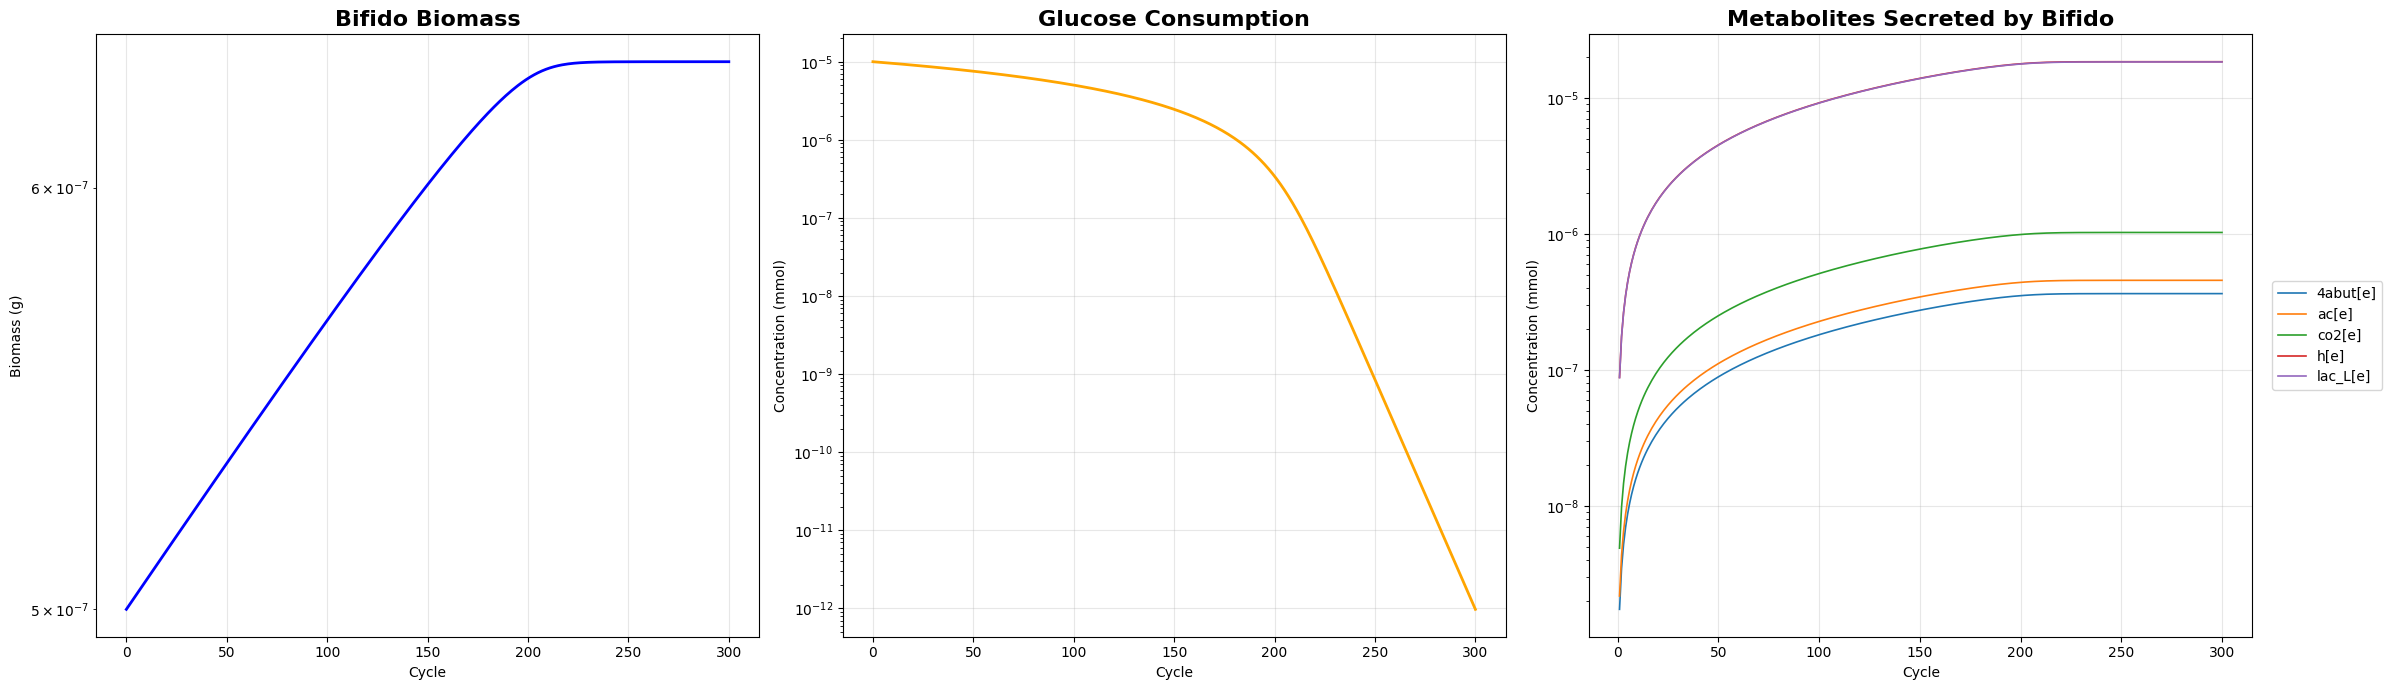

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Panel 1: Biomass
bio = sim_bif.total_biomass
#bio = bio[bio["cycle"] <= 10]
axs[0].plot(bio["cycle"], bio["Bifido"], lw=2, color="blue")
axs[0].set_yscale("log")
axs[0].set_xlabel("Cycle")
axs[0].set_ylabel("Biomass (g)")
axs[0].set_title("Bifido Biomass",fontsize=16, fontweight='bold')
axs[0].grid(alpha=0.3)

# Panel 2: Glucose
ts = sim_bif.get_metabolite_time_series()
#ts = ts[ts["cycle"] <= 10]
axs[1].plot(ts["cycle"], ts["glc_D[e]"], lw=2, color="orange")
axs[1].set_yscale("log")
axs[1].set_xlabel("Cycle")
axs[1].set_ylabel("Concentration (mmol)")
axs[1].set_title("Glucose Consumption",fontsize=16, fontweight='bold')
axs[1].grid(alpha=0.3)

# Panel 3: Secreted metabolites
initial_media_mets = background_met_ids | {"glc_D[e]"}
secreted = [m for m in ts.columns if m not in initial_media_mets and m not in ["cycle"] and "biomass" not in m.lower()]

for m in sorted(secreted):
    y = ts[m].to_numpy(dtype=float) # convert to numpy array
    y[y <= 0] = np.nan # replace negative or zero values with NaN
    axs[2].plot(ts["cycle"], y, lw=1.2, label=m)

axs[2].set_yscale("log")
axs[2].set_xlabel("Cycle")
axs[2].set_ylabel("Concentration (mmol)")
axs[2].set_title("Metabolites Secreted by Bifido",fontsize=16, fontweight='bold')
axs[2].legend(fontsize=10, loc="center left", bbox_to_anchor=(1.02, 0.5))
axs[2].grid(alpha=0.3)

fig.tight_layout()
plt.show()


# Eubacterium in mucus enviroment


In [5]:
model_eub = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
model_eub.id = 'Eubacterium'

for rxn in model_eub.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

met_to_ex_eub = {met.id: rxn.id for rxn in model_eub.exchanges
                 for met in rxn.metabolites if met.compartment == 'e'}
all_ex_mets_eub = set(met_to_ex_eub.keys())
print(f'Exchanges: {len(all_ex_mets_eub)}')

# FBA check
with model_eub as m:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
    for met_id in background_met_ids & all_ex_mets_eub:
        ex_id = met_to_ex_eub.get(met_id)
        if ex_id:
            m.reactions.get_by_id(ex_id).lower_bound = -1000.0
    ex_glc = met_to_ex_eub.get('glc_D[e]')
    if ex_glc:
        m.reactions.get_by_id(ex_glc).lower_bound = -GLC_CONC_mM
    sol = m.optimize()
    print(f'FBA growth rate: {sol.objective_value:.4f} 1/h')

# COMETS model
comets_eub = c.model(model_eub)
comets_eub.open_exchanges()
clean_non_ex(comets_eub)
comets_eub.initial_pop = [0, 0, INIT_BIOMASS]

# layout
layout2 = c.layout([comets_eub])
layout2.grid = [1, 1]
classify_and_set_media(layout2, all_ex_mets_eub)
layout2.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
layout2.set_specific_refresh('glc_D[e]', 0.0)

# Run
params2 = make_params()
sim_eub = c.comets(layout2, params2)
sim_eub.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchanges: 119
FBA growth rate: 0.4148 1/h

Running COMETS simulation ...

Debug Here ...
Done!


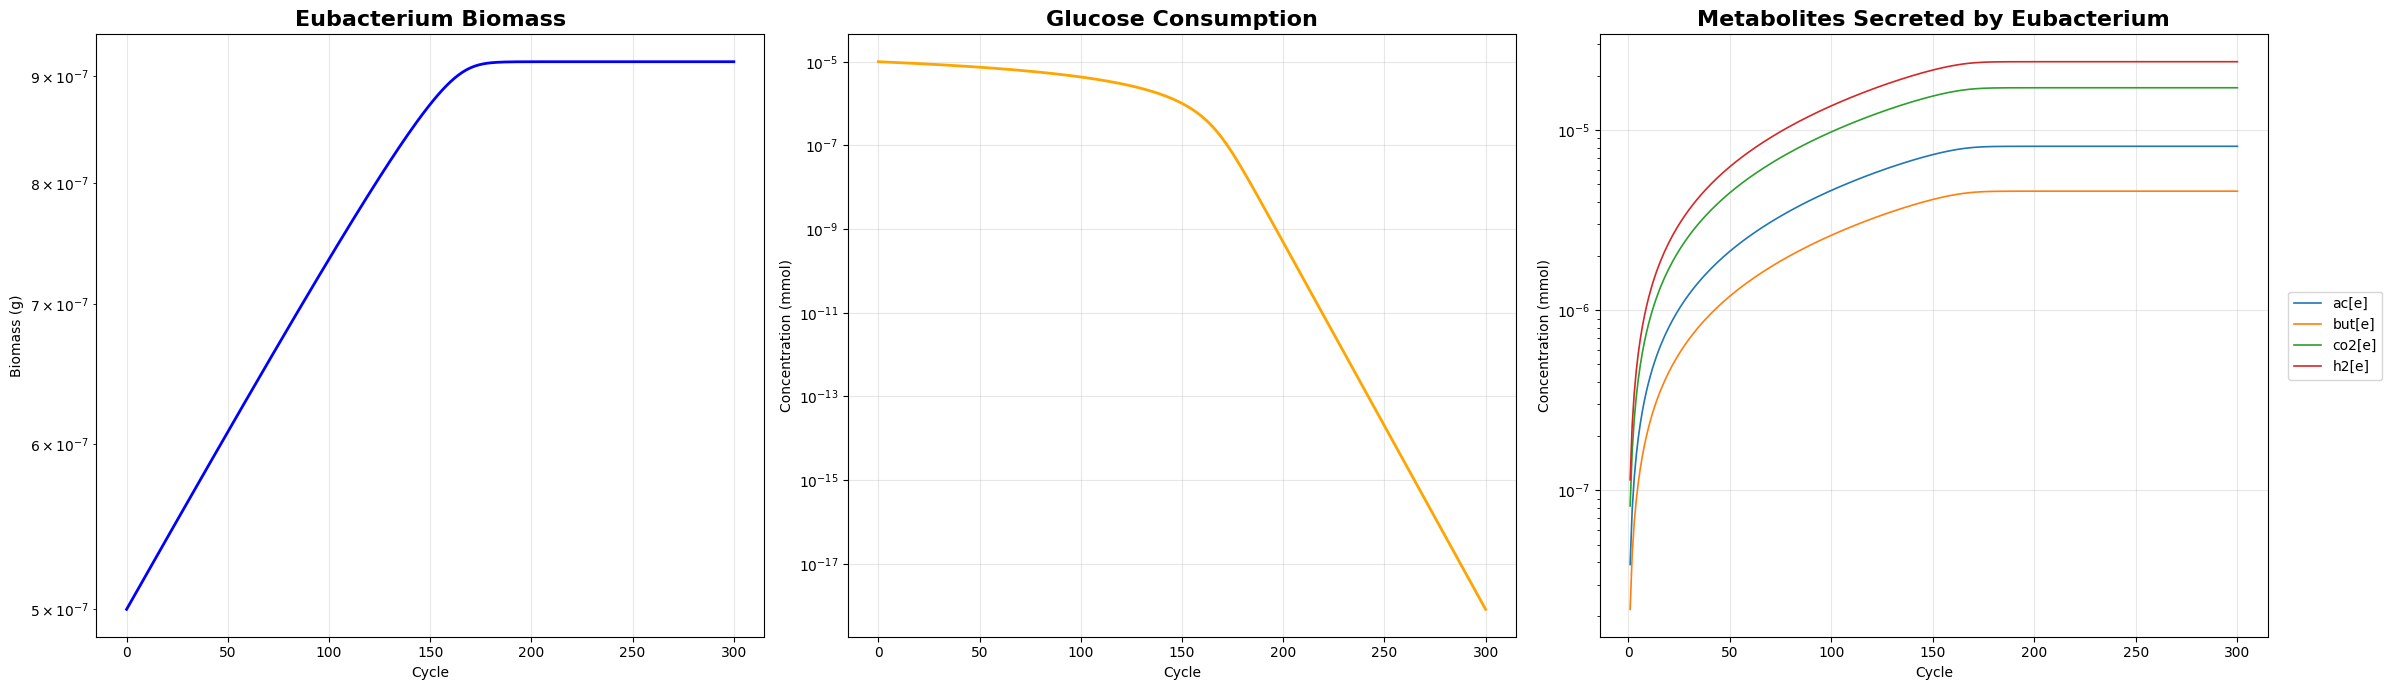

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Panel 1: Biomass
bio = sim_eub.total_biomass
# bio = bio[bio["cycle"] <= 10]
axs[0].plot(bio["cycle"], bio["Eubacterium"], lw=2, color="blue")
axs[0].set_yscale("log")
axs[0].set_xlabel("Cycle")
axs[0].set_ylabel("Biomass (g)")
axs[0].set_title("Eubacterium Biomass", fontsize=16, fontweight="bold")
axs[0].grid(alpha=0.3)

# Panel 2: Glucose
ts = sim_eub.get_metabolite_time_series()
# ts = ts[ts["cycle"] <= 10]
axs[1].plot(ts["cycle"], ts["glc_D[e]"], lw=2, color="orange")
axs[1].set_yscale("log")
axs[1].set_xlabel("Cycle")
axs[1].set_ylabel("Concentration (mmol)")
axs[1].set_title("Glucose Consumption", fontsize=16, fontweight="bold")
axs[1].grid(alpha=0.3)

# Panel 3: Secreted metabolites
initial_media_mets = background_met_ids | {"glc_D[e]"}
secreted = [m for m in ts.columns if m not in initial_media_mets and m not in ["cycle"] and "biomass" not in m.lower()]

for m in sorted(secreted):
    y = ts[m].to_numpy(dtype=float)
    y[y <= 0] = np.nan
    axs[2].plot(ts["cycle"], y, lw=1.2, label=m)

axs[2].set_yscale("log")
axs[2].set_xlabel("Cycle")
axs[2].set_ylabel("Concentration (mmol)")
axs[2].set_title("Metabolites Secreted by Eubacterium", fontsize=16, fontweight="bold")
axs[2].legend(fontsize=10, loc="center left", bbox_to_anchor=(1.02, 0.5))
axs[2].grid(alpha=0.3)

fig.tight_layout()
plt.show()